In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import json
from PIL import Image
import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp001'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
sub_df = pd.read_csv(root_dir / 'sample_submission.csv', index_col=0)


In [6]:
train_df.shape, test_df.shape

((131342, 7), (91486, 7))

In [7]:
import glob
import os
from tqdm.notebook import tqdm


def get_ground_truth(args):
    (collectionName, phoneName), df = args
    
    path = root_dir / f"train/{collectionName}/{phoneName}/ground_truth.csv"
    target_df = pd.read_csv(path)
    output_df = pd.DataFrame()
    # merge derived and target by 'millisSinceGpsEpoch'
    for epoch, epoch_df in df.groupby('millisSinceGpsEpoch'):
        idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
        epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
        epoch_df['epoch_diff'] = epoch_diff
        epoch_df['target_latDeg'] = target_df.loc[idx, 'latDeg']
        epoch_df['target_lngDeg'] = target_df.loc[idx, 'lngDeg']
        output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df

In [8]:
import multiprocessing

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(['collectionName','phoneName'])
    dfs = pool.imap_unordered(get_ground_truth, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

  0%|          | 0/73 [00:00<?, ?it/s]

In [9]:
train_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
...,...,...,...,...,...,...,...,...,...,...
2365,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2366,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2367,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2368,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613


In [11]:
train_df['epoch_diff'].unique()

array([0])

In [13]:
train_df['lat_diff'] = train_df["target_latDeg"] - train_df["latDeg"]
train_df['lng_diff'] = train_df["target_lngDeg"] - train_df["lngDeg"]
train_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg,lat_diff,lng_diff
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,6.540000e-07,-0.000041
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,-1.745700e-06,-0.000031
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,2.664700e-06,-0.000021
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,-6.623900e-06,-0.000011
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,-3.314000e-06,-0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...
2365,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,1.512830e-05,-0.000013
2366,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,2.833300e-06,-0.000030
2367,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,-1.616500e-05,-0.000016
2368,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,-1.990830e-05,-0.000030


(-0.0001, 0.0001)

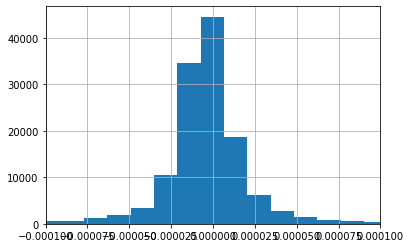

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
train_df["lat_diff"].hist(bins=5000, ax=ax)
ax.set_xlim(-0.0001, 0.0001)

(-0.0001, 0.0001)

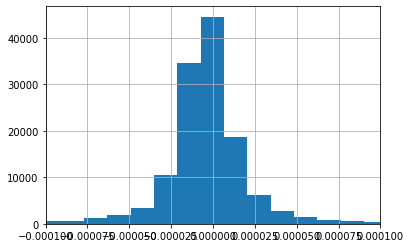

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
train_df["lat_diff"].hist(bins=5000, ax=ax)
ax.set_xlim(-0.0001, 0.0001)

In [18]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [20]:
train_df['distance'] = calc_haversine(train_df['target_latDeg'], train_df['target_lngDeg'],train_df['latDeg'],train_df['lngDeg'])

In [39]:
train_df['distance'].mean()

3.846848374995186

(0.0, 120.0)

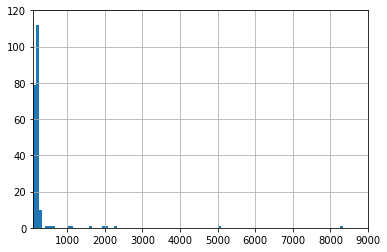

In [40]:
fig = plt.figure()
ax = fig.add_subplot()
train_df['distance'].hist(bins=100, ax=ax)
ax.set_xlim(100, 9000)
ax.set_ylim(0, 120)

In [43]:
train_df.loc[train_df['distance']<100, 'distance'].mean()

3.4035517137236786

(0.0, 2000.0)

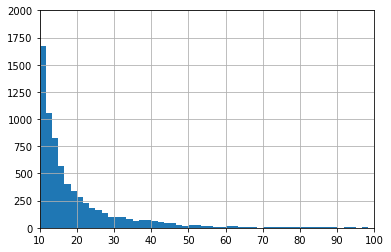

In [50]:
fig = plt.figure()
ax = fig.add_subplot()
train_df['distance'].hist(bins=5000, ax=ax)
ax.set_xlim(10, 100)
ax.set_ylim(0, 2000)

In [53]:
train_df.loc[(train_df['distance']>100)|(train_df['distance']<10), 'distance'].mean()

2.971190350392468

In [27]:
Itrain_df.sort_values('distance', ascending=False)

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg,lat_diff,lng_diff,distance
1713,2020-09-04-US-SF-1,Mi8,1283276368000,37.580437,-122.472214,13701.98,2020-09-04-US-SF-1_Mi8,0,37.630182,-122.401276,4.974549e-02,7.093736e-02,8340.257976
1493,2020-07-17-US-MTV-2,Mi8,1279064306000,37.398682,-122.013227,875.06,2020-07-17-US-MTV-2_Mi8,0,37.386959,-122.068502,-1.172309e-02,-5.527495e-02,5050.995543
730,2021-04-26-US-SVL-1,Mi8,1303513729000,37.372188,-121.994924,-6157.47,2021-04-26-US-SVL-1_Mi8,0,37.352232,-121.999514,-1.995582e-02,-4.589960e-03,2254.344928
501,2020-07-17-US-MTV-2,Mi8,1279063314000,37.453013,-122.291795,-1267.16,2020-07-17-US-MTV-2_Mi8,0,37.445063,-122.271124,-7.949982e-03,2.067030e-02,2026.294654
499,2020-07-17-US-MTV-2,Mi8,1279063312000,37.450409,-122.292772,-1740.02,2020-07-17-US-MTV-2_Mi8,0,37.445415,-122.271764,-4.994818e-03,2.100754e-02,1934.676643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2021-01-05-US-SVL-1,Mi8,1293916604000,37.352690,-122.061291,30.21,2021-01-05-US-SVL-1_Mi8,0,37.352690,-122.061291,4.000000e-08,1.550000e-07,0.014395
180,2021-01-04-US-RWC-1,Pixel5,1293832387434,37.435991,-122.242306,50.81,2021-01-04-US-RWC-1_Pixel5,0,37.435991,-122.242306,-4.440000e-08,1.163000e-07,0.011386
527,2021-01-04-US-RWC-1,Pixel4,1293832735437,37.458408,-122.289892,123.08,2021-01-04-US-RWC-1_Pixel4,0,37.458408,-122.289892,1.870000e-08,-1.248000e-07,0.011203
294,2020-09-04-US-SF-2,Pixel4XL,1283277861432,37.625660,-122.425186,6.46,2020-09-04-US-SF-2_Pixel4XL,0,37.625660,-122.425186,-8.540000e-08,3.929999e-08,0.010101


baselineで差分はこんなもの？  
座標だからmにすると実は大きい？  
loss計算時に座標からmに変換したほうがいい？

## preprocessing

In [14]:
train_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
...,...,...,...,...,...,...,...,...,...,...
2365,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2366,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2367,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2368,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613


In [15]:
whole_df = pd.concat([train_df, test_df]).reset_index(drop=True)
collection_size = whole_df['collectionName'].nunique()
phone_size = whole_df['phoneName'].nunique()

le_co = LabelEncoder()
le_co.fit(whole_df['collectionName'])
le_ph = LabelEncoder()
le_ph.fit(whole_df['phoneName'])

ss1 = StandardScaler()
ss1.fit(whole_df['heightAboveWgs84EllipsoidM'].to_numpy().reshape(-1, 1))
ss2 = StandardScaler()
ss2.fit(whole_df['latDeg'].to_numpy().reshape(-1, 1))
ss3 = StandardScaler()
ss3.fit(whole_df['lngDeg'].to_numpy().reshape(-1, 1))


def preprocess(input_df, le1=le_co, le2=le_ph, ss1=ss1, ss2=ss2, ss3=ss3):
    output_df = input_df.copy()
    
    # 正規化
    output_df['heightAboveWgs84EllipsoidM'] = ss1.transform(input_df['heightAboveWgs84EllipsoidM'].to_numpy().reshape(-1,1))
    output_df['latDeg'] = ss2.transform(input_df['latDeg'].to_numpy().reshape(-1,1))
    output_df['lngDeg'] = ss3.transform(input_df['lngDeg'].to_numpy().reshape(-1,1))

    # site_idのLE
    output_df['collectionName'] = le1.transform(input_df['collectionName'])
    output_df['phoneName'] = le2.transform(input_df['phoneName'])
    return output_df

train = preprocess(train_df).reset_index(drop=True)
test = preprocess(test_df).reset_index(drop=True)

In [16]:
train

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg
0,0,1,1273529463442,-0.216924,0.413939,-0.744054,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
1,0,1,1273529464442,-0.216897,0.413873,-0.731934,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
2,0,1,1273529465442,-0.216947,0.413806,-0.695732,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
3,0,1,1273529466442,-0.216841,0.413736,-0.724694,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
4,0,1,1273529467442,-0.216879,0.413786,-0.750822,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
...,...,...,...,...,...,...,...,...,...,...
131337,46,6,1303760315000,-1.234963,1.742837,-0.335285,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
131338,46,6,1303760316000,-1.234823,1.742951,-0.327415,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
131339,46,6,1303760317000,-1.234606,1.742855,-0.339378,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
131340,46,6,1303760318000,-1.234563,1.742951,-0.345359,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613


In [17]:
test

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
0,2,1,1273608785432,-0.296288,0.496193,-0.691010,2020-05-15-US-MTV-1_Pixel4
1,2,1,1273608786432,-0.296082,0.496283,-0.707852,2020-05-15-US-MTV-1_Pixel4
2,2,1,1273608787432,-0.296009,0.496292,-0.706121,2020-05-15-US-MTV-1_Pixel4
3,2,1,1273608788432,-0.296527,0.496125,-0.704074,2020-05-15-US-MTV-1_Pixel4
4,2,1,1273608789432,-0.296508,0.496058,-0.663622,2020-05-15-US-MTV-1_Pixel4
...,...,...,...,...,...,...,...
91481,47,6,1303763185000,-1.234062,1.744321,-0.340007,2021-04-29-US-SJC-3_SamsungS20Ultra
91482,47,6,1303763186000,-1.233989,1.744342,-0.323795,2021-04-29-US-SJC-3_SamsungS20Ultra
91483,47,6,1303763187000,-1.233916,1.744402,-0.272168,2021-04-29-US-SJC-3_SamsungS20Ultra
91484,47,6,1303763188000,-1.234043,1.744401,-0.297667,2021-04-29-US-SJC-3_SamsungS20Ultra


## model

In [80]:
# dataset
from torch.utils.data import Dataset, DataLoader
class OutdoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.collname_feats = df['collectionName'].to_numpy()
        self.phonename_feats = df['phoneName'].to_numpy()
        self.lat_feats = df['latDeg'].to_numpy()
        self.lng_feats = df['lngDeg'].to_numpy()
        self.height_feats = df['heightAboveWgs84EllipsoidM'].to_numpy()

        if phase in ['train', 'valid']:
            self.target = df[['target_latDeg', 'target_lngDeg']].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
    
        feature = {
            'collname':self.collname_feats[idx].astype(int),
            'phonename':self.phonename_feats[idx].astype(int),
            'lat':self.lat_feats[idx].astype(np.float32),
            'lng':self.lng_feats[idx].astype(np.float32),
            'height':self.height_feats[idx].astype(np.float32),
        }
        if self.phase in ['train', 'valid']:
            target = self.target[idx]
        else:
            target = None
        return feature, target

In [19]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    
    
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [85]:

# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, target = batch
        output = self.model(x)
        loss = self.criterion(output, target)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, target = batch
        output = self.model(x)
        loss = self.criterion(output, target)
        
        distances = calc_haversine(to_np(output[:, 0]), to_np(output[:, 1]), 
                                   to_np(target[:, 0]), to_np(target[:, 1]))
        d = np.mean(distances)
    
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Distance/val', d, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [86]:
# metric
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist


def to_np(input):
    return input.detach().cpu().numpy()

# oof
def evaluate(model, loaders, phase):
    lat_list = []
    lng_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            lat_list.append(to_np(output[:, 0]))
            lng_list.append(to_np(output[:, 1]))

    lat_list = np.concatenate(lat_list)
    lng_list = np.concatenate(lng_list)
    return lat_list, lng_list

In [87]:
train

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg
0,0,1,1273529463442,-0.216924,0.413939,-0.744054,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
1,0,1,1273529464442,-0.216897,0.413873,-0.731934,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
2,0,1,1273529465442,-0.216947,0.413806,-0.695732,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
3,0,1,1273529466442,-0.216841,0.413736,-0.724694,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
4,0,1,1273529467442,-0.216879,0.413786,-0.750822,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
...,...,...,...,...,...,...,...,...,...,...
131337,46,6,1303760315000,-1.234963,1.742837,-0.335285,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
131338,46,6,1303760316000,-1.234823,1.742951,-0.327415,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
131339,46,6,1303760317000,-1.234606,1.742855,-0.339378,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
131340,46,6,1303760318000,-1.234563,1.742951,-0.345359,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613


In [88]:
class MLPModel(nn.Module):
    def __init__(self, collection_size, phone_size, embedding_dim=32):
        super(MLPModel, self).__init__()
        # collection
        self.embedding_layer1 = nn.Sequential(
            nn.Embedding(collection_size, embedding_dim),
            nn.Flatten(start_dim=-1)            
        )
        # phone
        self.embedding_layer2 = nn.Sequential(
            nn.Embedding(phone_size, embedding_dim),
            nn.Flatten(start_dim=-1)           
        )

        # bssid, site, rssiの出力size
        feature_size = embedding_dim*2 + 3
        self.linear_layer1 = nn.Sequential(
            nn.BatchNorm1d(feature_size),
            nn.Dropout(0.3),
            nn.Linear(feature_size, 256),
            nn.ReLU()
        )

        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.linear_layer3 = nn.Sequential(
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 16),
            nn.ReLU()
        )

        self.fc = nn.Linear(16, 2)

    
    def forward(self, x):
        # input embedding
        batch_size = x["collname"].shape[0]
        x_coll = self.embedding_layer1(x['collname'])
        x_phone = self.embedding_layer2(x['phonename'])
        x = torch.cat([x_coll, x_phone, x['lat'].view(-1,1), x['lng'].view(-1,1), x['height'].view(-1,1)], dim=-1)  # (b, 67)

        # MLP
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        x = self.linear_layer3(x)

        # output [batch, 1, 1] -> [batch]
        x = self.fc(x).squeeze(1)
        return x

## train

In [89]:

oofs = []  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
# gkf = model_selection.GroupKFold(n_splits=N_SPLITS)

train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in skf.split(train, train.loc[:, 'collectionName'])]
for fold in range(5):
    # 指定したfoldのみループを回す
    if fold not in USE_FOLDS:
        continue

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_idx_for_train, val_idx_for_train = train_fold[fold]
    trn_df = train.loc[trn_idx_for_train, :].reset_index(drop=True)
    trn_df = trn_df.loc[:,['collectionName', 'phoneName', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM','target_latDeg','target_lngDeg']]
    
    val_df = train.loc[val_idx_for_train, :].reset_index(drop=True)
    val_df = val_df.loc[:,['collectionName', 'phoneName', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM','target_latDeg','target_lngDeg']]

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(OutdoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(OutdoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(OutdoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)

    # model
    model = MLPModel(collection_size, phone_size)  # +1としているのはLEを1スタートで始めているため
    model_name = model.__class__.__name__

    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=f"../../model/{EXP_NAME}",
        verbose=False,
        filename=f'{model_name}-{fold}')
    
    if MODEL_SAVE:
        callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=5,
        verbose=False,
        mode='min')
    callbacks.append(early_stop_callback)

    # loggers
    RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
    wandb.init(project='outdoor', entity='kuto5046', group=RUN_NAME)
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config['model_name'] = model_name
    wandb_config['comment'] = NOTES
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    # pretrained flag
    if PRETRAINED:
        ckpt = torch.load(PRETRAINED_PATH + f'{model_name}-{fold}.ckpt')
        learner.load_state_dict(ckpt['state_dict'])

    if not ONLY_PRED:
        trainer = pl.Trainer(
            logger=loggers, 
            callbacks=callbacks,
            max_epochs=MAX_EPOCHS,
            gpus=[0],
            fast_dev_run=DEBUG,
            deterministic=True,
            # precision=16,
            progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
            )

        trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval() 
    oof_df = train.loc[val_idx_for_train, ['collectionName', 'phoneName', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM','target_latDeg','target_lngDeg']].reset_index(drop=True)
    # oof_df = train.loc[val_idx_for_train, ['id', 'timestamp', 'x', 'y', 'floor', 'ix', 'iy', 'floor_str','path', 'site_id', 'site_id_str']].reset_index(drop=True)
    oof_x, oof_y = evaluate(model, loaders, phase="valid")
    oof_df["oof_latDeg"] = oof_x
    oof_df["oof_lngDeg"] = oof_y
    oofs.append(oof_df)
    
    val_score = np.mean(calc_haversine(to_np(output[:, 0]), to_np(output[:, 1]), 
                                   to_np(target[:, 0]), to_np(target[:, 1])))
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_x, preds_y))).T
    test_preds.columns = sub_df.columns
    # test_preds.to_csv(f'{EXP_NAME}_fold{fold}.csv', index=False)
    predictions.append(test_preds)

    if fold != 4:
        wandb.finish()

Fold 0


wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type     | Params
---------------------------------------
0 | model     | MLPModel | 55.1 K
1 | criterion | MSELoss  | 0     
---------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


ValueError: not enough values to unpack (expected 3, got 2)

## validation

In [ ]:
if len(USE_FOLDS) > 1:
    oofs_df = pd.concat(oofs)
else:
    oofs_df = oofs[0]

oofs_df['site_path_timestamp'] = oofs_df['site_id_str'].astype(str) + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df = oofs_df.sort_values('site_path_timestamp').reset_index(drop=True)
# oofs_df.to_csv("oof.csv", index=False)
oofs_df

In [ ]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
wandb_config['CV'] = oof_score
print(f"CV:{oof_score}")

In [ ]:
if len(USE_FOLDS) > 1:
    # foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
    # all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
    all_preds = pd.concat(predictions).reset_index().groupby('index').mean()
    all_preds['site_path_timestamp'] = predictions[0]['site_path_timestamp'].values
else:
    all_preds = predictions[0]

In [ ]:
sub.to_csv(EXP_NAME + '_sub.csv')